# Kinship computation and visualization

This script computes pairwise kinship coefficients of the probands from the **genea140** dataset and plots the individuals based on pairwise distances defined as *1 - kinship*.

In [1]:
!python --version

Python 3.10.12


Uniform Manifold Approximation and Projection (UMAP) will be used for dimensionality reduction, whereas Seaborn will be used for plotting. The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the pairwise kinship coefficients.

In [2]:
%pip install umap-learn seaborn https://github.com/GPhMorin/geneo/archive/main.zip

     \ 387.8 kB 5.9 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.0 MB/s eta 0:00:00
  Created wheel for geneo: filename=geneo-0.1.0-cp310-cp310-linux_x86_64.whl size=454498 sha256=8827d83e4727b93a098495b41633a3785002e57f897be650dc11077aea8a6abe
  Stored in directory: /tmp/pip-ephem-wheel-cache-0audavzi/wheels/89/82/c1/060b4460912dd0579653a87158a8c256172b90f4689b85460d
Successfully built geneo


The GENEO toolkit makes extensive use of Pandas dataframes, in this case, for the pairwise kinship coefficients and for the **pop140** dataset.

In [3]:
import pandas as pd
import umap
import seaborn as sns
import geneo as gen

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [4]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [5]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10, :]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [6]:
phi = gen.phi(genea140)
phi.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,0.501290,0.000235,0.005807,0.005166,0.008142
218089,0.000235,0.500118,0.000271,0.000230,0.000230
219947,0.005807,0.000271,0.502834,0.006361,0.007380
288708,0.005166,0.000230,0.006361,0.502508,0.008097
288764,0.008142,0.000230,0.007380,0.008097,0.506433


In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [7]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


The distance matrix is simply computed as *1 - kinship* since the kinship coefficients are themselves a kind of similarity.

In [8]:
dist = 1 - phi
dist.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,0.498710,0.999765,0.994193,0.994834,0.991858
218089,0.999765,0.499882,0.999729,0.999770,0.999770
219947,0.994193,0.999729,0.497166,0.993639,0.992620
288708,0.994834,0.999770,0.993639,0.497492,0.991903
288764,0.991858,0.999770,0.992620,0.991903,0.493567


UMAP offers the option `metric='precomputed'` to provide a precomputed distance matrix. `random_state=42` here is added only for reproducibility.

In [9]:
emb = umap.UMAP(metric='precomputed', random_state=42).fit_transform(dist)
emb[:10, :]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


array([[ 8.060947 , 13.676908 ],
       [ 7.4201407, 17.645185 ],
       [ 7.8590374, 14.956956 ],
       [ 8.095803 , 14.15862  ],
       [ 8.093091 , 14.430774 ],
       [ 7.9763064, 14.606297 ],
       [ 7.641311 , 14.529063 ],
       [ 7.9213867, 14.12508  ],
       [ 8.12668  , 14.432756 ],
       [ 8.4727335, 14.500424 ]], dtype=float32)

Probands are identified using the `gen.pro` function.

In [10]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [11]:
pops = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
pops[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

Finally, let's see the results.

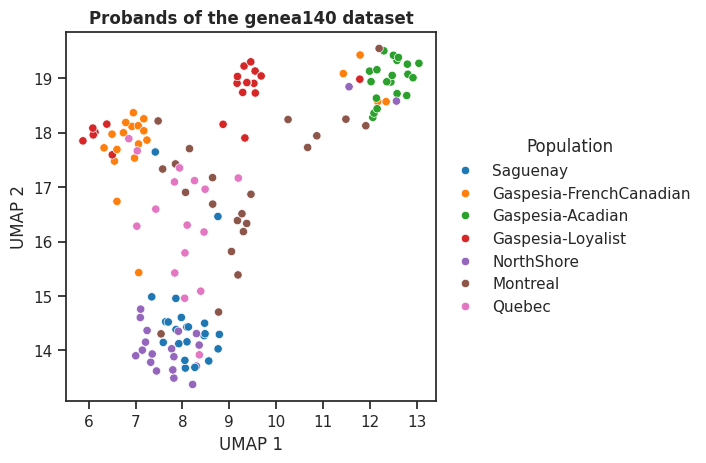

In [12]:
sns.set_theme(style='ticks')
ax = sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=pops, palette='tab10')
ax.set_aspect((max(emb[:, 0]) - min(emb[:, 0])) / (max(emb[:, 1] - min(emb[:, 1]))))
ax.set_title('Probands of the genea140 dataset', weight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 0.75),
                title='Population', frameon=False,)